In [184]:
import collections
import itertools as it

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [229]:
results = collections.defaultdict(lambda: collections.defaultdict(lambda: [[], [], []]))
with open("/tmp/gridsearch_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 100:
            continue  # Ignore warmup
        
        impl, c_in, c_out, image_h, image_w, delta_ns = [int(i) for i in l.strip().split()]
        results[(image_h, image_w)][(c_in, c_out)][impl].append(delta_ns)

bounds = {
    k: [[np.inf, np.inf], [-np.inf, -np.inf]]
    for k in results
}

for k, r in results.items():
    for c_in, c_out in r:
        bounds[k][0][0] =  min(bounds[k][0][0], c_in)
        bounds[k][0][1] =  min(bounds[k][0][0], c_out)
        bounds[k][1][0] =  max(bounds[k][1][0], c_in)
        bounds[k][1][1] =  max(bounds[k][1][0], c_out)

    assert(bounds[k][0][0] >= 0)
    assert(bounds[k][0][1] >= 0)

In [230]:
border_map = {
    k: np.ones((bounds[k][1][0] + 2, bounds[k][1][1] + 2, 3))
    for k in results
}

# These parameters control the brightness and contrast of the image
max_scale = 1.2
offset = 0.5

for k, r in results.items():
    count = 0
    best_counts = [0, 0, 0]

    for (c_in, c_out), v in r.items():
        if all([len(vi) >= 3 for vi in v]):
            v = np.array([np.mean(vi) for vi in v])
            v /= np.min(v)
            v -= offset
            v = max_scale / v

            best_counts[np.argmin(v)] += 1
            count += 1

            border_map[k][c_in, c_out, :] = torch.softmax(torch.Tensor(v), dim=0).numpy()
    print(count)
    print(k, best_counts)

9216
(128, 128) [2454, 4663, 2099]


0 / 9604 points interpolated


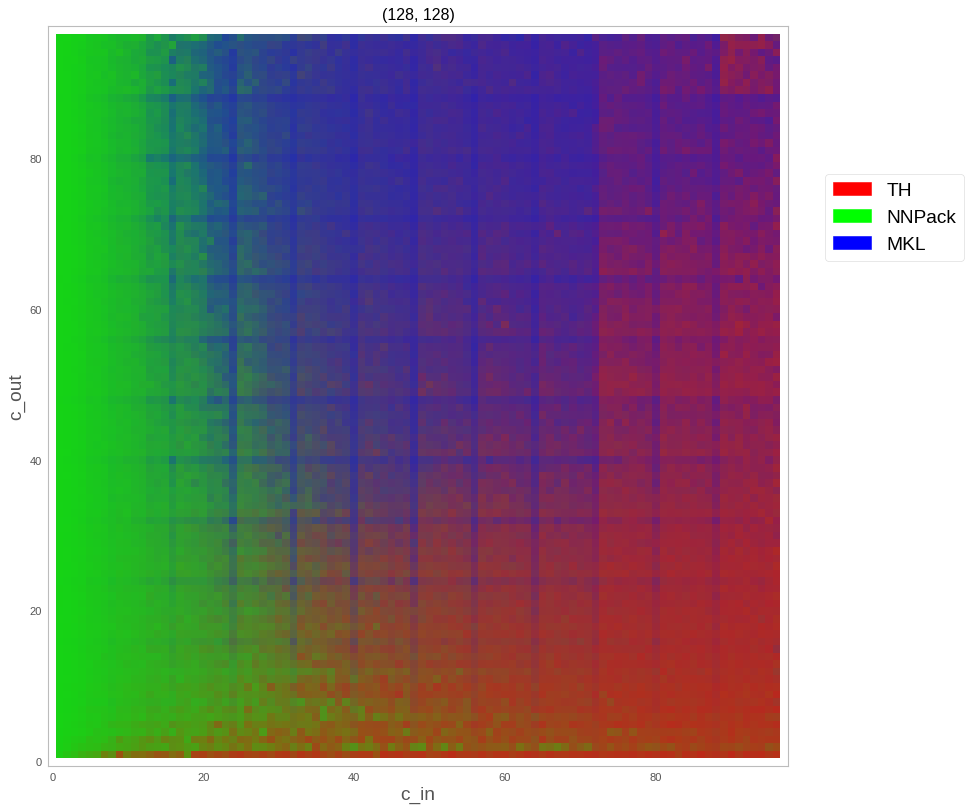

In [231]:
fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
subplot_w = int(np.ceil(np.sqrt(len(results))))
subplot_h = int(np.ceil(len(results) / subplot_w))
for i, k in enumerate(sorted(border_map.keys())):
    bm = border_map[k]
    
    # Interpolate missing points
    bm = bm.copy()
    ind_to_interpolate = []
    for index_0 in range(1, bm.shape[0] - 1):
        for index_1 in range(1, bm.shape[1] - 1):
            if sum(bm[index_0, index_1, :]) == 3:
                ind_to_interpolate.append((index_0, index_1))
    for index_0, index_1 in ind_to_interpolate * 5:
        bm[index_0, index_1, :] = (
            bm[index_0 - 1, index_1, :] +
            bm[index_0 + 1, index_1, :] +
            bm[index_0, index_1 - 1, :] +
            bm[index_0, index_1 + 1, :]) / 4
        
    print(f"{len(ind_to_interpolate)} / {bm.shape[0] * bm.shape[1]} points interpolated")
    
    plt.subplot(subplot_h, subplot_w, i + 1)
    plt.imshow(bm, interpolation="none", origin="lower")
    plt.grid(None)
    plt.xlabel("c_in", fontsize="xx-large")
    plt.ylabel("c_out", fontsize="xx-large")
    plt.title(str(k))
patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 0.8), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()

In [182]:
drilldown_results = collections.defaultdict(lambda: [[], [], []])
with open("/tmp/drilldown_results.txt", "rt") as f:
    for i, l in enumerate(f):
        if i < 1000:
            continue  # Ignore warmup
            
        impl, c_in, c_out, image_h, image_w, delta_ns = [int(i) for i in l.strip().split()]
#         assert (image_h, image_w) == (128, 128)
        assert (image_h, image_w) == (64, 64)
        drilldown_results[(c_in, c_out)][impl].append(delta_ns)

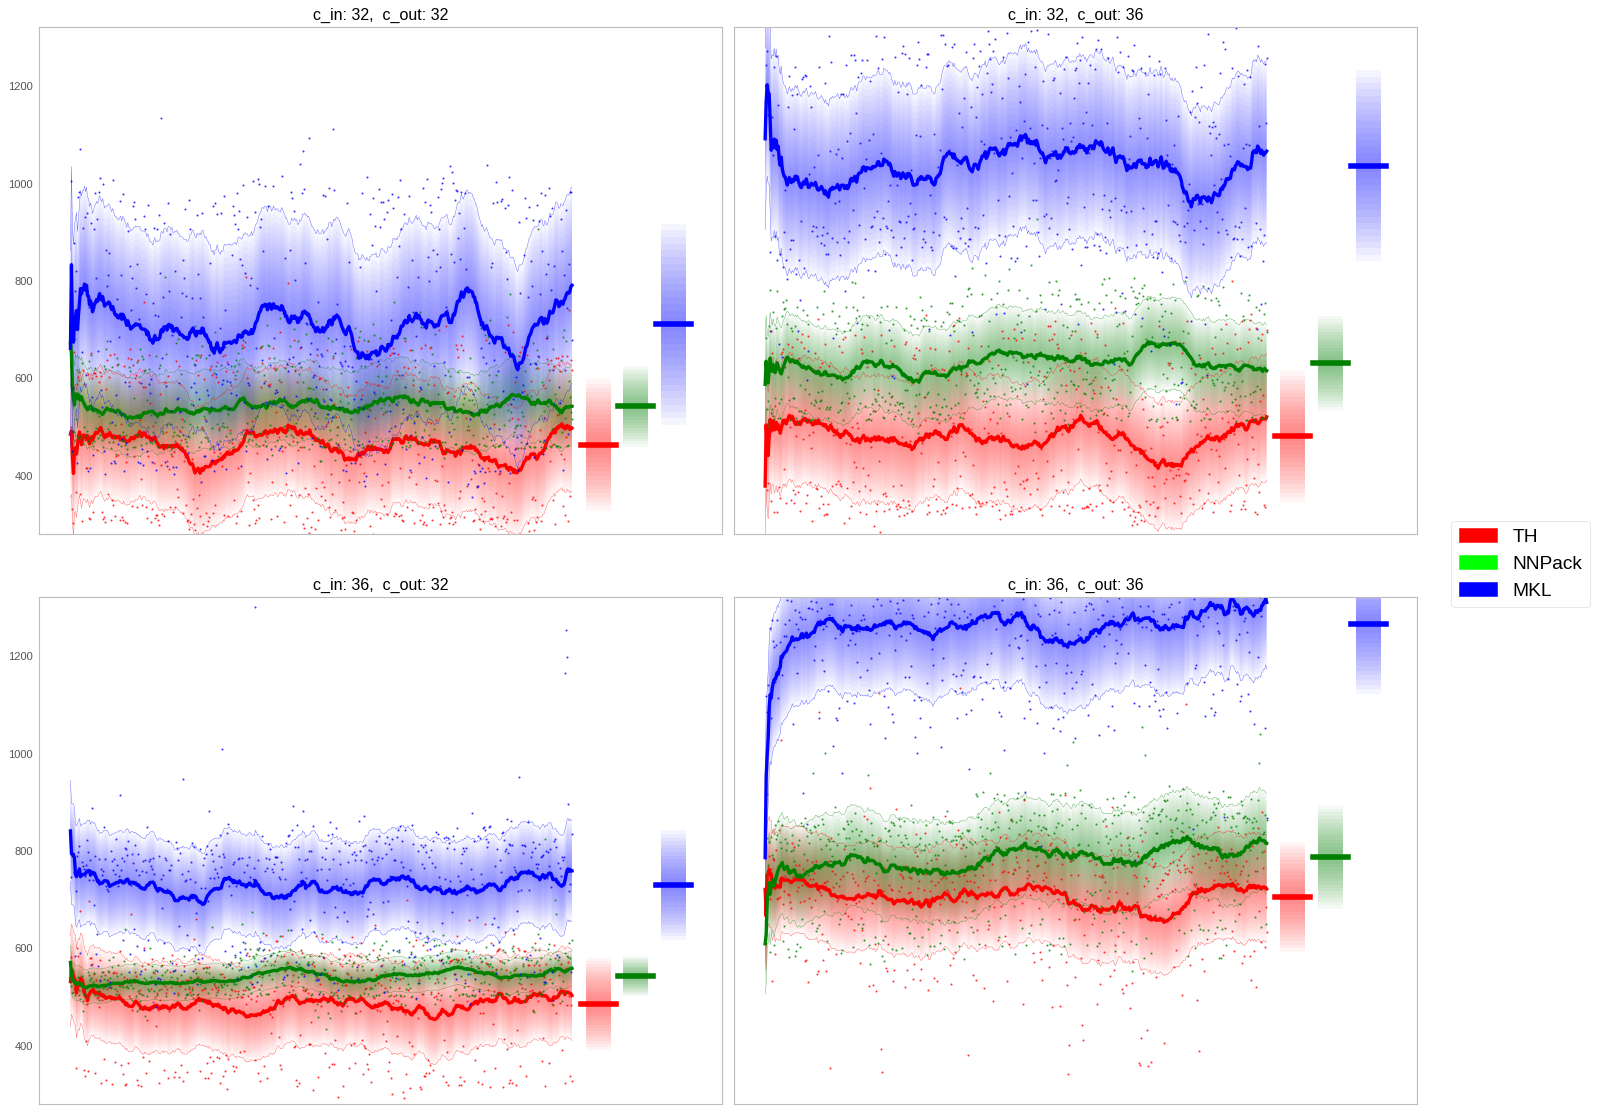

In [183]:
window = 50

n = 500
flat_values = list(it.chain(*it.chain(*drilldown_results.values())))
y_min = np.percentile(flat_values, 0.01) * 1e-3
y_max = np.percentile(flat_values, 98) * 1e-3

fig = plt.figure(figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
drilldown_keys = sorted(drilldown_results.keys())
subplot_w = int(np.ceil(np.sqrt(len(drilldown_keys))))
subplot_h = int(np.ceil(len(drilldown_keys) / subplot_w))
for drilldown_index, (c_in, c_out) in enumerate(drilldown_keys):
    plt.subplot(subplot_h, subplot_w, drilldown_index + 1)
    for j, color in enumerate(["r", "g", "b"]):
        y = np.array(drilldown_results[(c_in, c_out)][j][:n]) * 1e-3
    
        running_mean, running_std = [], []
        for i in range(len(y)):
            y_subset = y[max(0, i + 1 - window):i + 1]
            running_mean.append(np.mean(y_subset))
            running_std.append(np.std(y_subset))
        running_mean, running_std = np.array(running_mean), np.mean(running_std)
        
        plt.plot(y, "." + color, markersize=2, alpha=0.6)
        plt.plot(running_mean, color, linewidth=3)
        
        shade_k = 15
        for i in range(1, shade_k + 1):
            y_lower = running_mean - running_std * i / shade_k
            y_upper = running_mean + running_std * i / shade_k
            plt.fill_between(np.arange(n), y_lower, y_upper, facecolor=color, alpha=0.5/shade_k)
            
            plt.fill_between(
                n * 1.025 + j * n * 0.075 + np.array([0, n * 0.05]),
                [np.mean(y) - np.std(y) * i / shade_k] * 2,
                [np.mean(y) + np.std(y) * i / shade_k] * 2,
                facecolor=color,
                alpha=0.6/shade_k,
            )
        plt.plot(y_lower, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(y_upper, "-" + color, linewidth=0.4, alpha=0.6)
        plt.plot(n * 1.025 + j * n * 0.075 + np.array([-n * 0.01, n * 0.06]), [np.mean(y)] * 2, color=color, linewidth=5)
        

    plt.title(f"c_in: {c_in},  c_out: {c_out}")
    plt.ylim(bottom=y_min, top=y_max)
    plt.grid(None)
    
    plt.gca().axes.get_xaxis().set_visible(False)
    if drilldown_index % subplot_w:
        plt.gca().axes.get_yaxis().set_visible(False)

patches = [mpatches.Patch(color=c, label=l) for c, l in (([1, 0, 0], "TH"), ([0, 1, 0], "NNPack"), ([0, 0, 1], "MKL"))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.15), loc=2, borderaxespad=0. , fontsize="xx-large")
fig.tight_layout()